<a href="https://colab.research.google.com/github/ArthurCBx/PyTorch-DeepLearning-Udemy/blob/main/02_NeuralNetworkClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting wheter something is one thing or another (there can be multiple things as the options).

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/

## What is a classification problem ?
Examples:
* Is this email spam or not ? -> Binary classification
* What food is in this photo ? -> Multiclass classification
* What tags should this article have? -> multilabel classification

## 1. Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [ ]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [ ]:
# Make DataFame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


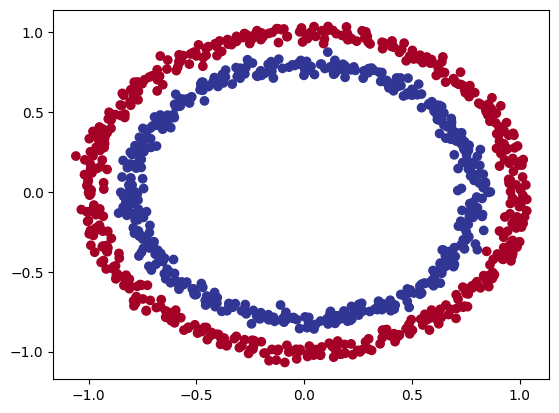

In [ ]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: The data we're working with is often referred to as toy dataset, a dataset that is small enough to experimnt but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [ ]:
# Turn data into tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2, #20% if data will be test and 80% will be train
                                                 random_state=42) #Just a manual seed for randomness

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Let's create a model that:

1. Subclasses `nn.Module`
2. Create `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a forward() method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [ ]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscale to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # the in_features must match the out_features of the previous layer.
                                                            # Outputs 1 value to match the shape of y

  # 3. Define a forward() method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

  # 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [ ]:
# Make prediction
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
  print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
  print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example, for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For some common choices of loss functions and optimizers - https://pytorch.org/docs/stable/optim.html

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on binary cross entropy (BCE), check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

* For different optimizers see `torch.optim`

In [ ]:
# Setup loss function
#loss_fn = nn.BCELoss() #BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function built-in

# Setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train a model

To train our model we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass calssification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [ ]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [ ]:
# Find the predicted labes
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds,y_pred_labels.squeeze()))

#Get rid of extra dimension

y_preds.squeeze()

tensor([[ True,  True, False,  True, False],
        [ True,  True, False,  True, False],
        [False, False,  True, False,  True],
        [ True,  True, False,  True, False],
        [False, False,  True, False,  True]], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Bulding a training and testing loop

In [ ]:
!nvidia-smi


Thu Jan 16 22:03:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              34W /  70W |    151MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build train and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), #nn.BCELoss epects prediction probabilities as input
                 #y_train)
  loss = loss_fn(y_logits, #nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69796, Acc: 51.88% | Test Loss: 0.69440, Test Acc: 58.00%
Epoch: 10 | Loss: 0.69590, Acc: 51.25% | Test Loss: 0.69305, Test Acc: 53.00%
Epoch: 20 | Loss: 0.69490, Acc: 51.62% | Test Loss: 0.69254, Test Acc: 49.50%
Epoch: 30 | Loss: 0.69435, Acc: 51.12% | Test Loss: 0.69236, Test Acc: 49.50%
Epoch: 40 | Loss: 0.69401, Acc: 50.88% | Test Loss: 0.69232, Test Acc: 51.00%
Epoch: 50 | Loss: 0.69378, Acc: 50.25% | Test Loss: 0.69234, Test Acc: 50.00%
Epoch: 60 | Loss: 0.69362, Acc: 50.00% | Test Loss: 0.69239, Test Acc: 51.50%
Epoch: 70 | Loss: 0.69351, Acc: 50.25% | Test Loss: 0.69246, Test Acc: 51.00%
Epoch: 80 | Loss: 0.69342, Acc: 49.88% | Test Loss: 0.69254, Test Acc: 50.00%
Epoch: 90 | Loss: 0.69336, Acc: 49.88% | Test Loss: 0.69262, Test Acc: 53.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything

So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

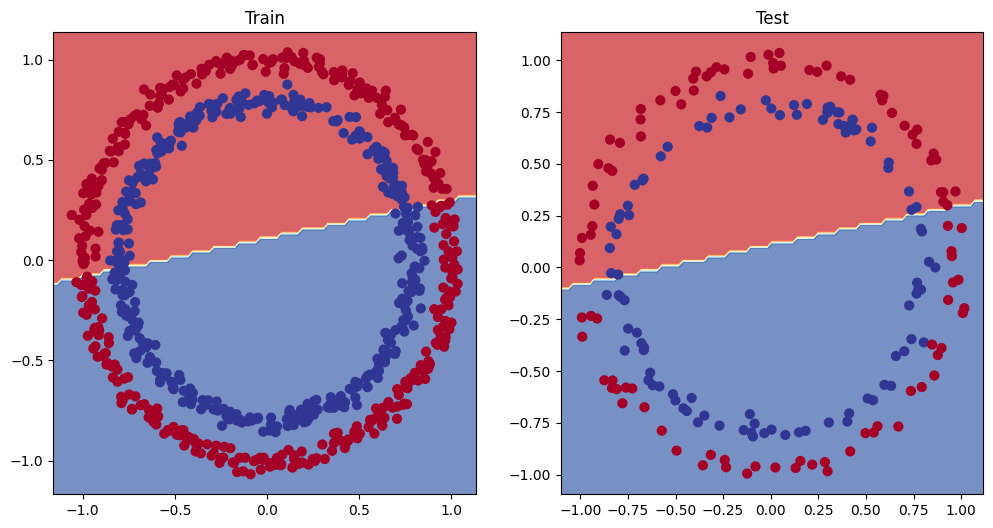

In [ ]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # rows,columns, index
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these optins are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, 

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [ ]:
# Write a training and evaluation loop for model_1

torch.manual_seed(42)

# Train for longer
epochs = 1000

# Put the data on the target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate the loss
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    #Print out whats happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test Acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test Acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test Acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test Acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test Acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%


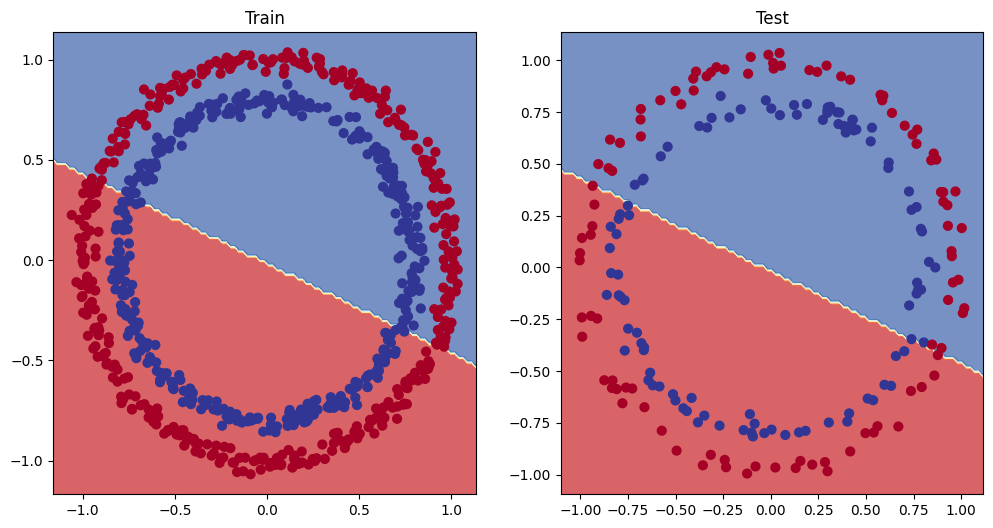

In [ ]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # rows,columns, index
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [ ]:
# Create some data (same as notebook 01)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Create train and test split
train_split = int(0.8 * len(X_regression))

X_train_reg = X_regression[:train_split]
y_train_reg = y_regression[:train_split]

X_test_reg = X_regression[train_split:]
y_test_reg = y_regression[train_split:]

# Check the length of each
len(X_train_reg), len(y_train_reg), len(X_test_reg), len(y_test_reg)

(80, 80, 20, 20)

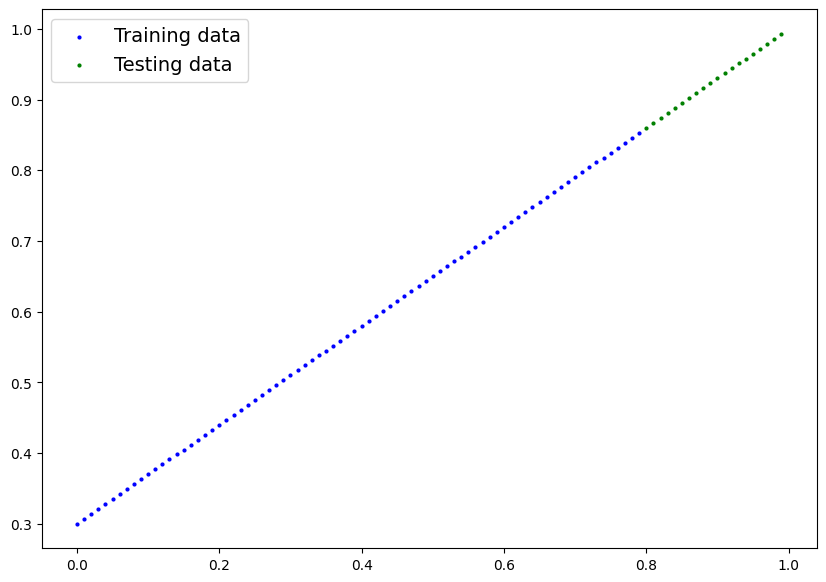

In [ ]:
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg,
                 predictions=None)

### 5.2 Adjusting `model_1` to fit a straight line

In [ ]:
# Same architecture as model_1
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.000001)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_reg,y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg,y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
  # Training
  model_2.train()

  y_preds = model_2(X_train_reg)
  loss = loss_fn(y_preds,y_train_reg)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_reg)
    test_loss = loss_fn(test_pred,y_test_reg)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.95396
Epoch: 100 | Loss: 0.75948 | Test Loss: 0.95353
Epoch: 200 | Loss: 0.75910 | Test Loss: 0.95309
Epoch: 300 | Loss: 0.75872 | Test Loss: 0.95266
Epoch: 400 | Loss: 0.75833 | Test Loss: 0.95223
Epoch: 500 | Loss: 0.75795 | Test Loss: 0.95180
Epoch: 600 | Loss: 0.75757 | Test Loss: 0.95136
Epoch: 700 | Loss: 0.75719 | Test Loss: 0.95093
Epoch: 800 | Loss: 0.75681 | Test Loss: 0.95050
Epoch: 900 | Loss: 0.75643 | Test Loss: 0.95007


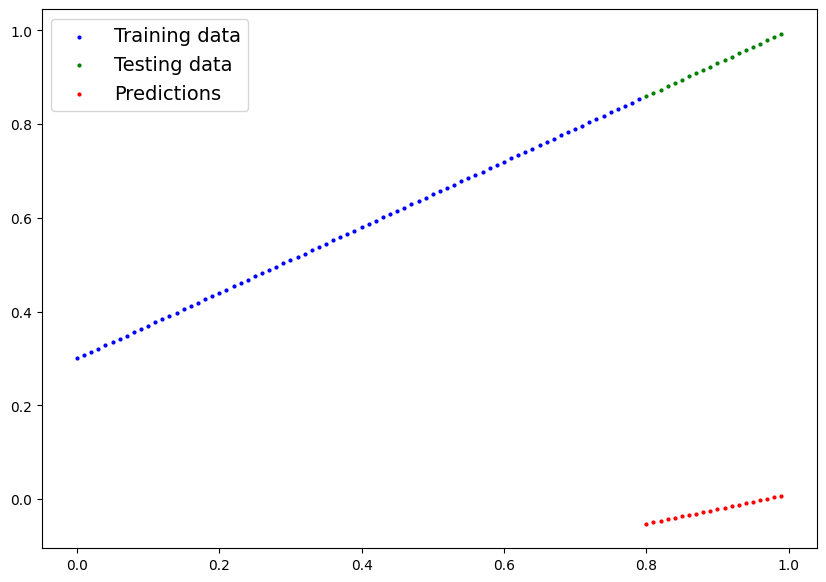

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make some predictions
with torch.inference_mode():
  y_preds = model_2(X_test_reg)

plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

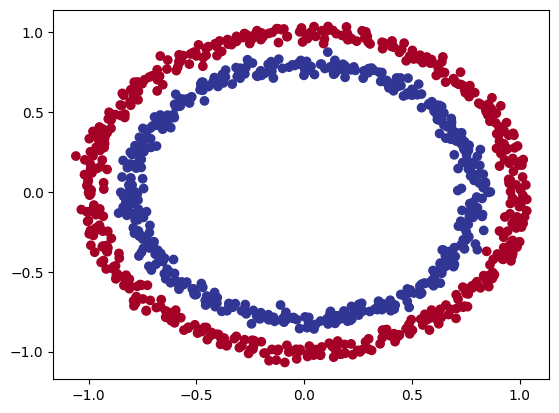

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu);

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
* Linear = straight linear
* Non-linear = Non-straight lines

In [ ]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()


  def forward(self,x):
    # Where should we put our non-linear activation functions?
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [ ]:
# Random seeds

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1.
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2.
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss takes in logits as first input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3.
  optimizer.zero_grad()

  # 4.
  loss.backward()

  # 5.
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Test Acc: 79.00%


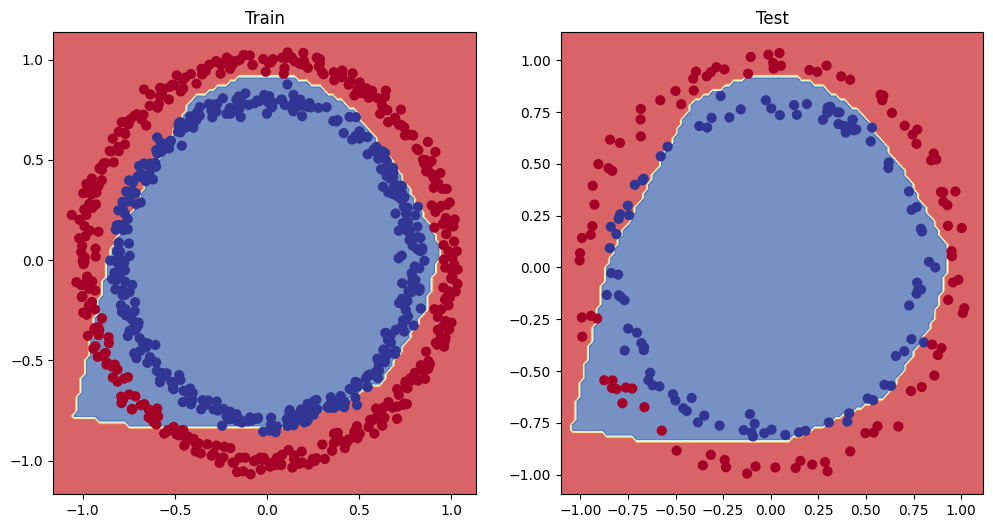

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # rows,columns, index
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [ ]:
# Create a tensor
A = torch.arange(-10,10,1,dtype=torch.float32)

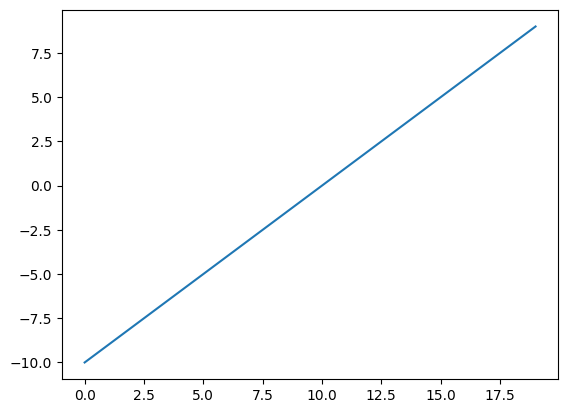

In [ ]:
# Visualize the tensor
plt.plot(A);

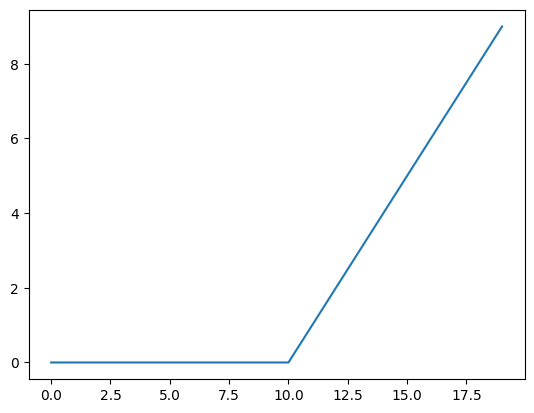

In [ ]:
plt.plot(torch.relu(A));

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0),x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

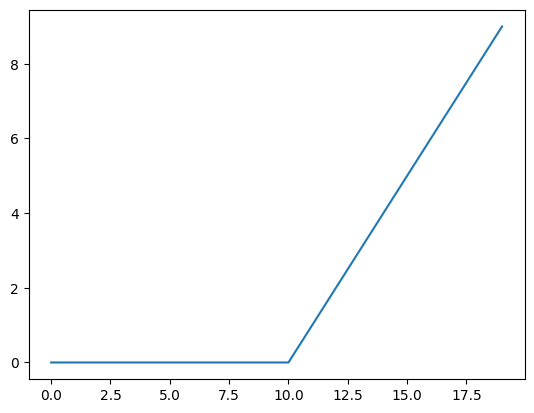

In [ ]:
# Plot ReLU activation function
plt.plot(relu(A))

In [ ]:
# Now let's do the same for the sigmoid

def sigmoid(x):
  return 1 / (1 + torch.exp(-x))


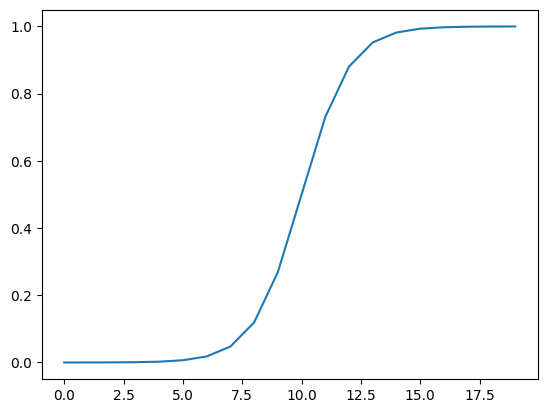

In [ ]:
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs dog, spam vs not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another

### 8.1 Creating a tou multi-class dataset

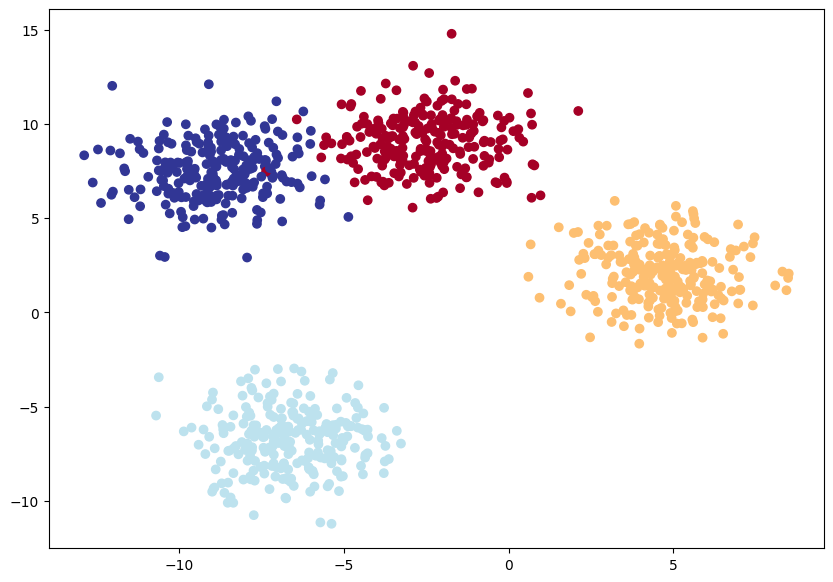

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyoeroarameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.50, # give the clusters a little shake up
                           random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Build a multi-class classification model
from torch import nn
class BlobModelV1(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int, optional): number of hidden units between layers. Defaults as 8.
    """
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModelV1(input_features=2,
                      output_features=4,
                      hidden_units=8).to(device)
model_4

BlobModelV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [ ]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - updates our model parameters to try to reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)



### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [ ]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])
print(torch.softmax(y_logits,dim=1)[:5].argmax(dim=1))

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')
tensor([1, 0, 0, 0, 0], device='cuda:0')


In [ ]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.0266, Acc: 99.25% | Test Loss: 0.0165, Test Acc: 99.50%
Epoch: 10 | Loss: 0.0263, Acc: 99.25% | Test Loss: 0.0162, Test Acc: 99.50%
Epoch: 20 | Loss: 0.0261, Acc: 99.25% | Test Loss: 0.0159, Test Acc: 99.50%
Epoch: 30 | Loss: 0.0259, Acc: 99.25% | Test Loss: 0.0157, Test Acc: 99.50%
Epoch: 40 | Loss: 0.0258, Acc: 99.25% | Test Loss: 0.0155, Test Acc: 99.50%
Epoch: 50 | Loss: 0.0256, Acc: 99.25% | Test Loss: 0.0152, Test Acc: 99.50%
Epoch: 60 | Loss: 0.0255, Acc: 99.25% | Test Loss: 0.0150, Test Acc: 99.50%
Epoch: 70 | Loss: 0.0254, Acc: 99.25% | Test Loss: 0.0149, Test Acc: 99.50%
Epoch: 80 | Loss: 0.0252, Acc: 99.25% | Test Loss: 0.0147, Test Acc: 99.50%
Epoch: 90 | Loss: 0.0251, Acc: 99.25% | Test Loss: 0.0145, Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_pred_probs = torch.softmax(y_logits,dim=1)
y_preds = torch.argmax(y_pred_probs,dim=1)
print(y_preds[:5])
print(y_blob_test[:5])


tensor([1, 3, 2, 1, 0], device='cuda:0')
tensor([1, 3, 2, 1, 0], device='cuda:0')


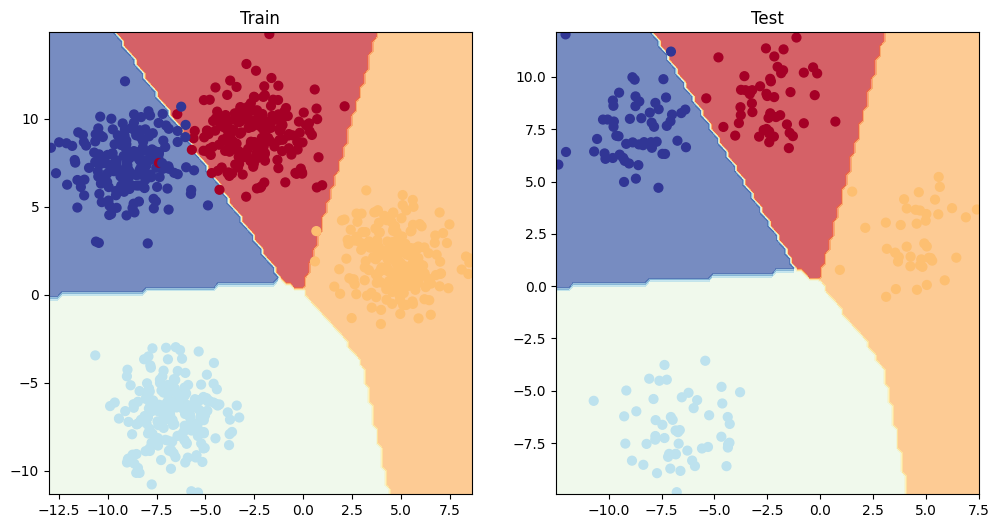

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # rows,columns, index
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test);

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many our model gets right
* Precision
* Recall
* F1 - score
* Confusion matrix
* Classification report

If you want access to a lot of PyTorch metrics, see TorchMetrics

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 21.4 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass",num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

## Exercises & Extra-curriculum

### 1) Make a binary classification dataset with Scikit-Learn's `make_moons()` function

In [ ]:
import sklearn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch

X, y = make_moons(n_samples=1000,
                  noise=0.07,
                  random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train

tensor([[ 2.0144,  0.2466],
        [-1.0187,  0.4045],
        [-0.1252,  1.0580],
        ...,
        [-0.7748,  0.6186],
        [ 1.0494,  0.1170],
        [ 1.9290,  0.1262]])

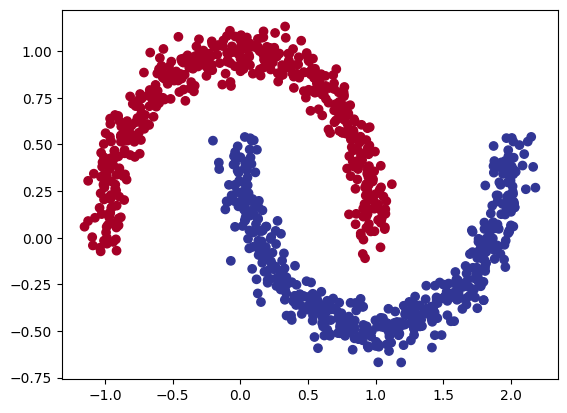

In [ ]:
# Just for visualization
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu);

### 2) Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [ ]:
from torch import nn
model_EX = nn.Sequential(
    nn.Linear(in_features=2,out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,out_features=1)
)
device = "cuda" if torch.cuda.is_available() else "cpu"

model_EX.to(device)


Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

### 3) Setup a binary classification compatible loss function and optimizer to use when training the model.

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_EX.parameters(),
                            lr=0.1)

### 4) Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

In [ ]:
from torchmetrics.classification import BinaryAccuracy
metric = BinaryAccuracy().to(device)

In [ ]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_EX.train()

  y_logits = model_EX(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = metric(y_pred,y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_EX.eval()
  with torch.inference_mode():
    test_logits = model_EX(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = metric(test_pred,y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6990, Acc: 0.50% | Test Loss: 0.6945, Test Acc: 0.50%
Epoch: 100 | Loss: 0.2975, Acc: 0.87% | Test Loss: 0.3040, Test Acc: 0.86%
Epoch: 200 | Loss: 0.2327, Acc: 0.89% | Test Loss: 0.2263, Test Acc: 0.90%
Epoch: 300 | Loss: 0.2105, Acc: 0.90% | Test Loss: 0.2003, Test Acc: 0.92%
Epoch: 400 | Loss: 0.1791, Acc: 0.93% | Test Loss: 0.1688, Test Acc: 0.94%
Epoch: 500 | Loss: 0.1366, Acc: 0.94% | Test Loss: 0.1270, Test Acc: 0.95%
Epoch: 600 | Loss: 0.0945, Acc: 0.97% | Test Loss: 0.0859, Test Acc: 0.98%
Epoch: 700 | Loss: 0.0619, Acc: 0.99% | Test Loss: 0.0548, Test Acc: 0.99%
Epoch: 800 | Loss: 0.0417, Acc: 0.99% | Test Loss: 0.0360, Test Acc: 1.00%
Epoch: 900 | Loss: 0.0299, Acc: 1.00% | Test Loss: 0.0250, Test Acc: 1.00%


### 5) Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

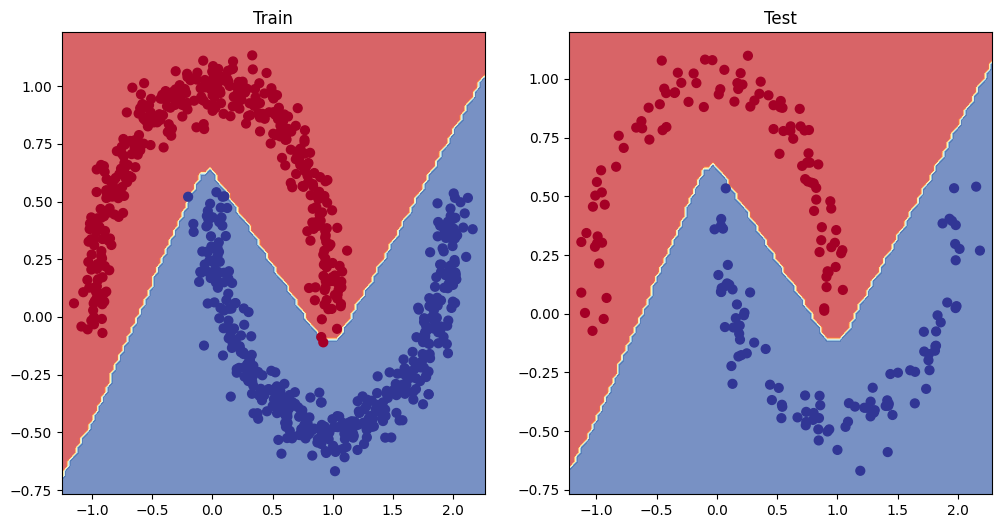

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # rows,columns, index
plt.title("Train")
plot_decision_boundary(model_EX, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_EX, X_test, y_test);


### 6) Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

In [ ]:
def tanh(x):
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

### 7) Create a multi-class dataset using the spirals data creation function from CS231n

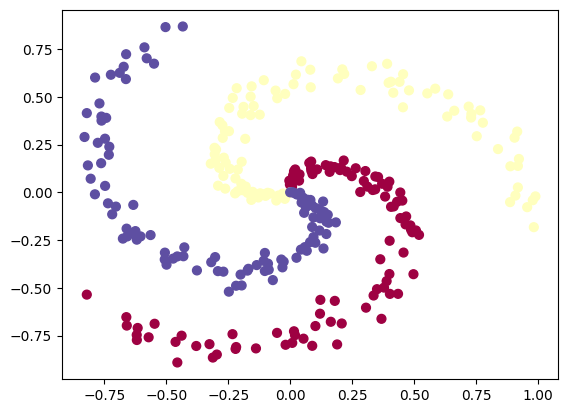

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
model_EXM = nn.Sequential(
    nn.Linear(in_features=2,out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16,out_features=3))
device = "cuda" if torch.cuda.is_available() else "cpu"

model_EXM.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=3, bias=True)
)

In [ ]:
loss_fn_M = nn.CrossEntropyLoss()

optimizer_M = torch.optim.Adam(params=model_EXM.parameters(),
                            lr=0.01)

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_EXM.train()

  y_logits = model_EXM(X_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn_M(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)

  optimizer_M.zero_grad()
  loss.backward()
  optimizer_M.step()

  ### Testing
  model_EXM.eval()
  with torch.inference_mode():
    test_logits = model_EXM(X_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn_M(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.0156, Acc: 99.17% | Test Loss: 0.1723, Test Acc: 98.33%
Epoch: 100 | Loss: 0.0153, Acc: 99.17% | Test Loss: 0.1816, Test Acc: 98.33%
Epoch: 200 | Loss: 0.0150, Acc: 99.17% | Test Loss: 0.1878, Test Acc: 98.33%
Epoch: 300 | Loss: 0.0148, Acc: 99.17% | Test Loss: 0.1944, Test Acc: 98.33%
Epoch: 400 | Loss: 0.0146, Acc: 99.17% | Test Loss: 0.1990, Test Acc: 98.33%
Epoch: 500 | Loss: 0.0144, Acc: 99.17% | Test Loss: 0.2025, Test Acc: 98.33%
Epoch: 600 | Loss: 0.0144, Acc: 99.17% | Test Loss: 0.2061, Test Acc: 98.33%
Epoch: 700 | Loss: 0.0143, Acc: 99.17% | Test Loss: 0.2100, Test Acc: 98.33%
Epoch: 800 | Loss: 0.0143, Acc: 99.17% | Test Loss: 0.2143, Test Acc: 98.33%
Epoch: 900 | Loss: 0.0141, Acc: 99.17% | Test Loss: 0.2169, Test Acc: 98.33%


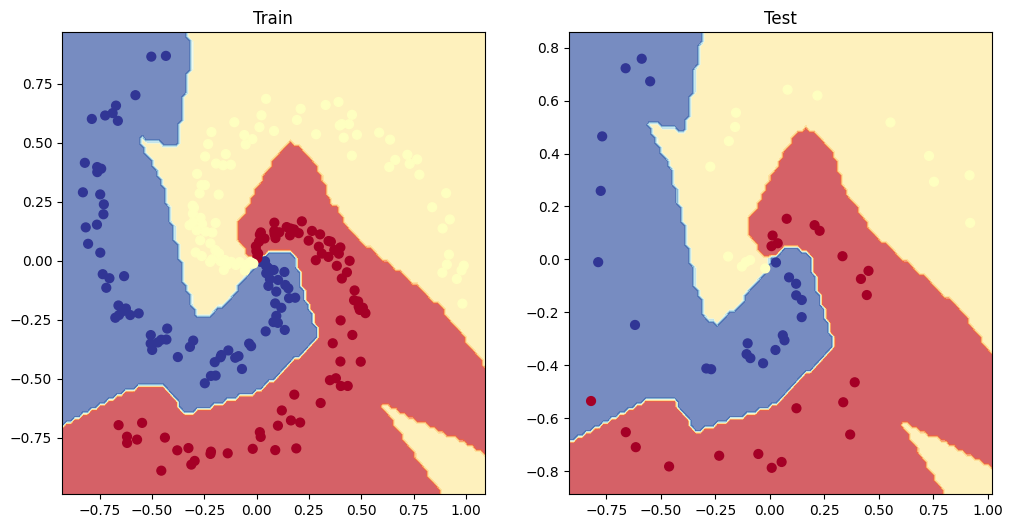

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # rows,columns, index
plt.title("Train")
plot_decision_boundary(model_EXM, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_EXM, X_test, y_test);